# Cluster Ask.Cyberinfrastructure Posts with Gensim

We are going to use Gensim, a Python library for extraction of semantic topics from documents to cluster the extracted posts from AskCI. 

We will start with raw text from posts, generate embeddings for each using Doc2Vec, and then cluster the embeddings to find the semantic structure of the posts. What we'd like to see is that posts cluster nicely with tags, or perhaps we could look at what kind of posts are most well liked (based on votes). The algorithms we will be using are unsupervised, meaning that we don't need to provide any labels for training.

See the documentation at: <a>https://radimrehurek.com/gensim/index.html</a>

In [1]:
from gensim import corpora, models, similarities
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from sklearn import cluster, metrics
from sklearn.manifold import TSNE
import seaborn
import matplotlib.pylab as plt
%matplotlib inline

import json
import os
import re

date_folder = "2019-10-19"
board = "ask.cyberinfrastructure.org"
categories = ["q-a", "Area-for-open-ended-topics-of-interest"]

topics = []
labels = []

def read_json(json_file):
    with open(json_file, 'r') as filey:
        content = json.loads(filey.read())
    return content
        
# Read in list of topics, each line compiled posts from it
for category in categories:
    json_path = os.path.join(date_folder, "%s-%s-posts-%s.json" %(board, category, date_folder))
    content = read_json(json_path)
    for label, sentences in content.items():
        topics.append(' '.join(sentences))
        labels.append(label)

In [2]:
# remove html formatting replace newlines
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    removelinks = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    cleantext = re.sub(removelinks, '', cleantext)
    cleantext = cleantext.replace('\n', ' ')
    cleantext = re.sub("[^a-zA-Z0-9 -]", ' ', cleantext)
    return cleantext

cleaned = [cleanhtml(document) for document in topics]

In [3]:
# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [[word for word in document.lower().split() if word not in stoplist]
         for document in cleaned]

In [4]:
# remove words that appear only once
from collections import defaultdict
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [[token for token in text if frequency[token] > 1]
         for text in texts]

In [5]:
# Generate tagged documents
docs = []
for i, text in enumerate(texts):
    docs.append(TaggedDocument(text, [i]))

# build model, wv is mapping between words and embeddings
model = Doc2Vec(docs, vector_size=5, window=2, min_count=1, workers=4)

# document embeddings
print(model)
print(len(model.docvecs.vectors_docs))

Doc2Vec(dm/m,d5,n5,w2,s0.001,t4)
179


(179, 2)


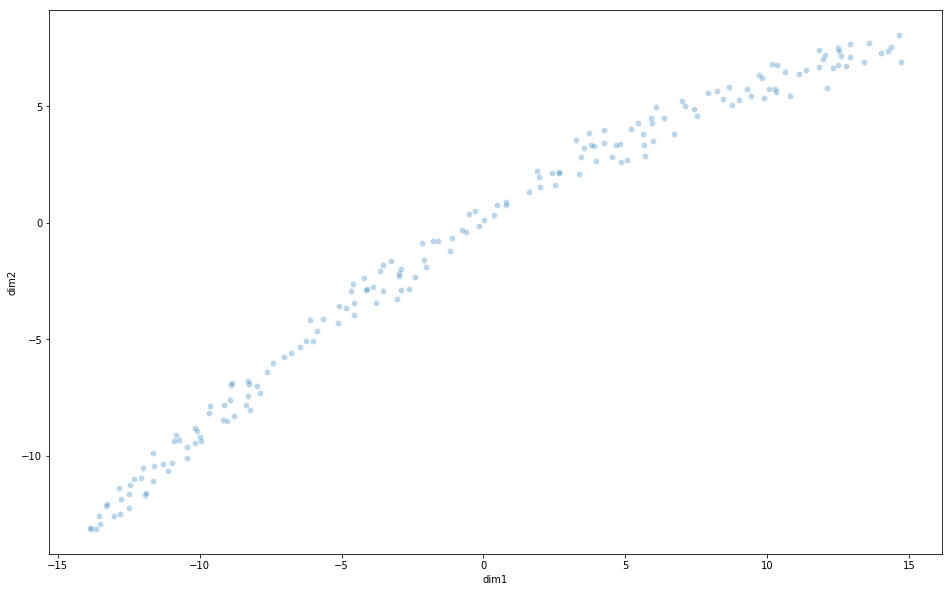

In [8]:
# Try TSNE
X_embedded = TSNE(n_components=2).fit_transform(model.docvecs.vectors_docs)
print(X_embedded.shape)
import pandas

df = pandas.DataFrame(X_embedded)
df.columns = ['dim1', 'dim2']

plt.figure(figsize=(16,10))
seaborn.scatterplot(
    x='dim1',
    y='dim2',
    data=df,
    palette=seaborn.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

In [16]:
# Notebooks are crap, save data to make a real plot in d3
# list of dicts with x,y, and link

data = []
for i, row in enumerate(X_embedded):
    label = labels[i]
    data.append({"x": row[0], "y": row[1], "post_id": label})
    
print(data)

with open("askci-post-tsne-179x2.json", 'w') as filey:
    filey.writelines(json.dumps(data), indent=4)

[{'x': -12.818639, 'y': -12.50576, 'post_id': '303'}, {'x': 2.6621914, 'y': 2.1877372, 'post_id': '74'}, {'x': 11.372341, 'y': 6.5536199, 'post_id': '264'}, {'x': -0.50026566, 'y': 0.38764876, 'post_id': '215'}, {'x': -6.0202446, 'y': -5.074439, 'post_id': '552'}, {'x': -1.1196027, 'y': -0.66016328, 'post_id': '606'}, {'x': 5.6631298, 'y': 3.3453472, 'post_id': '921'}, {'x': 14.2593, 'y': 7.3455124, 'post_id': '854'}, {'x': 3.9722512, 'y': 2.6498168, 'post_id': '863'}, {'x': 11.836795, 'y': 7.4149494, 'post_id': '108'}, {'x': 10.169871, 'y': 6.8217397, 'post_id': '126'}, {'x': 8.2148514, 'y': 5.6446247, 'post_id': '242'}, {'x': 3.7286005, 'y': 3.8670108, 'post_id': '943'}, {'x': -12.830366, 'y': -11.371675, 'post_id': '73'}, {'x': -13.299064, 'y': -12.128494, 'post_id': '553'}, {'x': -9.1815119, 'y': -8.4472771, 'post_id': '92'}, {'x': -8.2820492, 'y': -7.41816, 'post_id': '30'}, {'x': 3.8761721, 'y': 3.29351, 'post_id': '238'}, {'x': 7.0841727, 'y': 4.9918022, 'post_id': '504'}, {'x':

TypeError: Object of type 'float32' is not JSON serializable